### Satellite-Based Crop Health Detection using CNN and NDVI

This notebook trains a Convolutional Neural Network (CNN) to classify crop health from preprocessed satellite NDVI images. The goal is to create a model that can accurately distinguish between 'Healthy', 'Rust-infected', and 'Other' stress conditions in crops, providing a valuable tool for precision agriculture.

---

### Step 1: Setup and Path Configuration

First, we import all necessary libraries and configure the file paths. By creating dynamic, absolute paths, we ensure that the notebook can locate the data and save the results correctly, regardless of the project's location on the file system. This is a crucial step for creating reproducible and portable code.

In [16]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

# --- Dynamic Path Setup ---
# This setup assumes the notebook is in a 'notebooks' folder, one level below the project root.
try:
    # This works when running as a script
    NOTEBOOK_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # This is a fallback for interactive environments like Jupyter
    NOTEBOOK_DIR = os.path.abspath('')

BASE_DIR = os.path.dirname(NOTEBOOK_DIR)
# A check to ensure the base directory is correct, even if run from the root
if 'notebooks' not in os.path.basename(BASE_DIR):
   BASE_DIR = os.path.join(NOTEBOOK_DIR, '..')
   BASE_DIR = os.path.abspath(BASE_DIR)

# Add the project's root directory to the Python path to allow for module imports
if BASE_DIR not in sys.path:
    sys.path.append(BASE_DIR)

# Now that the path is set, we can import our custom model
from models.cnn_model import build_cnn_model

# Construct absolute paths to prevent file not found errors
DATA_DIR = os.path.join(BASE_DIR, 'data', 'processed')
OUTPUT_DIR = os.path.join(BASE_DIR, 'outputs')
MODEL_SAVE_PATH = os.path.join(OUTPUT_DIR, 'saved_model', 'crop_health_cnn.h5')
PREDICTIONS_SAVE_PATH = os.path.join(OUTPUT_DIR, 'predictions', 'validation_predictions.csv')

# Ensure all necessary output directories exist before use
os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)
os.makedirs(os.path.dirname(PREDICTIONS_SAVE_PATH), exist_ok=True)

print(f"✅ Project Base Directory set to: {BASE_DIR}")
print(f"✅ Processed Data will be loaded from: {DATA_DIR}")

✅ Project Base Directory set to: d:\AI_ML_DS\CropHealthProject
✅ Processed Data will be loaded from: d:\AI_ML_DS\CropHealthProject\data\processed


### Step 2: Load and Prepare the NDVI Dataset

Here, we load the preprocessed `.npy` NDVI data files from the `data/processed` directory. The data is then prepared for the neural network by:
1.  **Reshaping**: Adding a channel dimension for the CNN.
2.  **Normalizing**: Scaling NDVI values from `[-1, 1]` to a `[0, 1]` range, which is optimal for model training.
3.  **One-Hot Encoding**: Converting integer labels to a categorical format.
4.  **Splitting**: Dividing the data into training and validation sets, using stratification to maintain the original class distribution.

In [17]:
PROCESSED_PATH = DATA_DIR
CLASSES = ['Health', 'Rust', 'Other']
IMG_SIZE = 64
X, y = [], []



# --- Load and label data ---
for idx, cls in enumerate(CLASSES):
    class_dir = os.path.join(PROCESSED_PATH, cls)
    for file in os.listdir(class_dir):
        if file.endswith('.npy'):
            arr = np.load(os.path.join(class_dir, file))
            X.append(arr)
            y.append(idx)  # 0 for Health, 1 for Rust, 2 for Other
            
            
# --- Convert to arrays and reshape ---
X = X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1).astype(np.float32)
y = np.array(y)

# --- Normalize NDVI to [0, 1] if not already ---
X = (X + 1) / 2.0  # NDVI [-1,1] → [0,1]

# --- One-hot encode labels ---
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, num_classes=3)

# --- Train-test split ---
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Step 3: Build and Train the CNN Model

We now use our custom CNN architecture imported from `models/cnn_model.py`. We print the model's summary to verify its structure and then proceed to train it on our prepared dataset for 20 epochs. The training progress will be monitored using the validation set.

In [18]:
from models.cnn_model import build_cnn_model


model = build_cnn_model(input_shape=(IMG_SIZE, IMG_SIZE, 1), num_classes=3)
model.summary()

print("\n------- Starting Model Training -------")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=500,
    batch_size=32,
    verbose=1
)
print("--- 🎉 Model Training Complete ---")

C:\Users\bhart\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,142,659 (4.36 MB)

 Trainable params: 1,142,211 (4.36 MB)

 Non-trainable params: 448 (1.75 KB)


------- Starting Model Training -------
Epoch 1/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.5077 - loss: 4.0830 - val_accuracy: 0.2667 - val_loss: 1.0810
Epoch 2/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.5852 - loss: 1.4104 - val_accuracy: 0.3333 - val_loss: 1.2201
Epoch 3/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.5663 - loss: 1.1192 - val_accuracy: 0.3333 - val_loss: 1.4071
Epoch 4/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.6012 - loss: 0.8993 - val_accuracy: 0.3333 - val_loss: 1.5428
Epoch 5/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.5809 - loss: 0.8891 - val_accuracy: 0.3333 - val_loss: 1.5405
Epoch 6/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.5740 - loss: 0.8517 - val_accuracy: 0.3333 - val_loss: 1.5692
Epoch 7/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.6556 - loss: 0.8184 - val_accuracy: 0.3333 - val_loss: 1.7041
Epoch 8/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy

### Step 4: Visualize Training History

Plotting the training and validation accuracy and loss over epochs is essential. This visualization allows us to diagnose the model's learning behavior, such as identifying overfitting (where validation performance degrades while training performance improves) or underfitting.

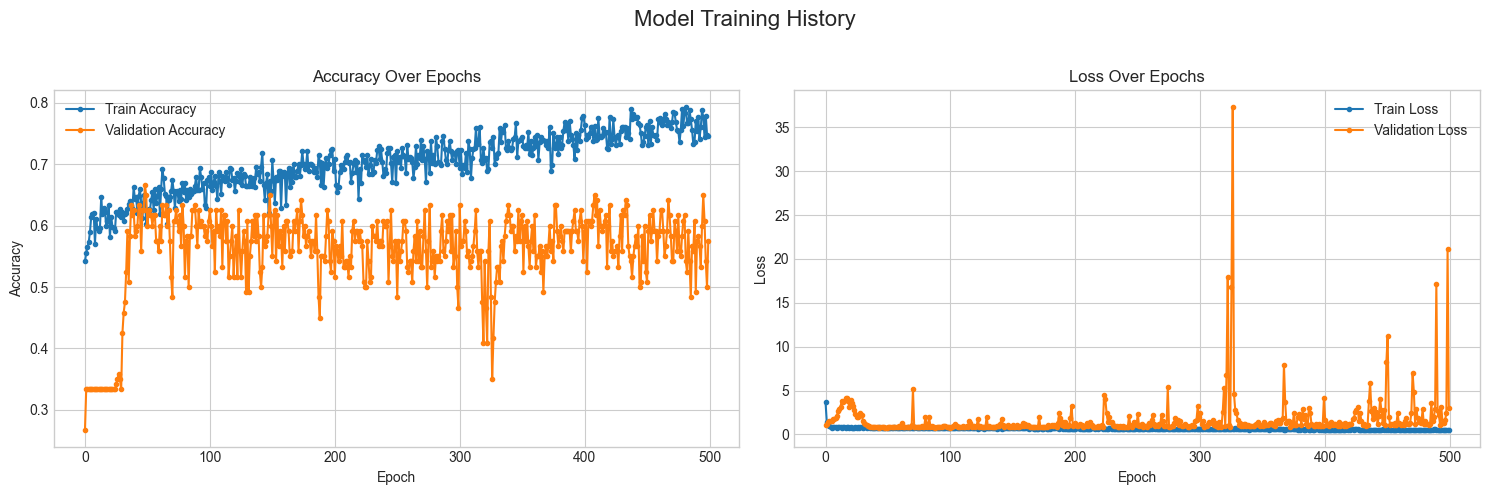

In [19]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Model Training History', fontsize=16)

# Plot training & validation accuracy values
ax1.plot(history.history['accuracy'], label='Train Accuracy', marker='.')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='.')
ax1.set_title('Accuracy Over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='upper left')

# Plot training & validation loss values
ax2.plot(history.history['loss'], label='Train Loss', marker='.')
ax2.plot(history.history['val_loss'], label='Validation Loss', marker='.')
ax2.set_title('Loss Over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Step 5: Save the Trained Model

After successful training, we save the entire model (architecture, learned weights, and optimizer state) to a single H5 file. This allows us to easily load and reuse the model for future predictions without needing to retrain it.

In [20]:
model.save(MODEL_SAVE_PATH)
print(f"✅ Model saved successfully to: {MODEL_SAVE_PATH}")

✅ Model saved successfully to: d:\AI_ML_DS\CropHealthProject\outputs\saved_model\crop_health_cnn.h5


### Step 6: Evaluate Model Performance

We now evaluate the final model's performance on the unseen validation data. A **classification report** provides key metrics like precision, recall, and F1-score for each class, while the **confusion matrix** gives a visual breakdown of correct and incorrect predictions.

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
Classification Report:
              precision    recall  f1-score   support

      Health       0.44      0.68      0.53        40
        Rust       0.75      0.30      0.43        40
       Other       0.70      0.75      0.72        40

    accuracy                           0.57       120
   macro avg       0.63      0.58      0.56       120
weighted avg       0.63      0.57      0.56       120



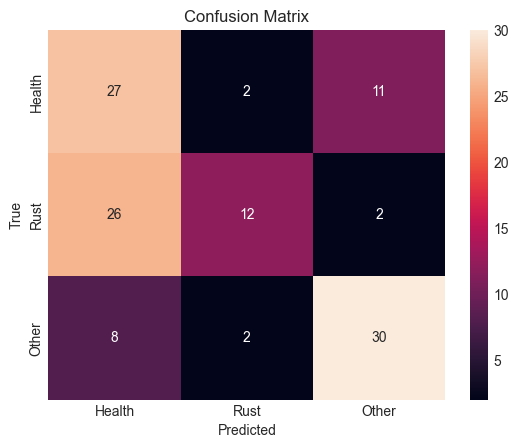

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred = model.predict(X_val)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_val, axis=1)

print("Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=CLASSES))

import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### Step 7: Save Validation Predictions

For more detailed error analysis, we save the true and predicted labels from the validation set to a CSV file. This allows us to inspect specific instances where the model made incorrect predictions.

In [22]:
results_df = pd.DataFrame({
    'True_Label': [CLASSES[i] for i in y_true_labels],
    'Predicted_Label': [CLASSES[i] for i in y_pred_labels]
})

results_df.to_csv(PREDICTIONS_SAVE_PATH, index=False)
print(f"✅ Saved validation predictions to: {PREDICTIONS_SAVE_PATH}")
display(results_df.head())

✅ Saved validation predictions to: d:\AI_ML_DS\CropHealthProject\outputs\predictions\validation_predictions.csv


,True_Label,Predicted_Label
0,Other,Other
1,Other,Other
2,Rust,Rust
3,Health,Health
4,Rust,Health


### Step 8: Create a Prediction Function

Finally, we create a reusable function that encapsulates the entire prediction pipeline for a single NDVI image. This function loads the saved model, preprocesses the input image in the same way as the training data, and returns the predicted class name.

In [23]:
def predict_single_ndvi(npy_path, model_path):
    """
    Loads a single NDVI .npy file and predicts its crop health class.
    
    Args:
        npy_path (str): The file path to the .npy NDVI image.
        model_path (str): The file path to the saved .h5 Keras model.
        
    Returns:
        str: The predicted class name (e.g., 'Health') or None if an error occurs.
    """
    try:
        model = load_model(model_path)
        ndvi = np.load(npy_path)
        ndvi_reshaped = ndvi.reshape(1, IMG_SIZE, IMG_SIZE, 1).astype('float32')
        ndvi_normalized = (ndvi_reshaped + 1) / 2.0

        pred_probs = model.predict(ndvi_normalized)
        predicted_class_index = np.argmax(pred_probs)
        predicted_class_name = CLASSES[predicted_class_index]

        print(f"File: {os.path.basename(npy_path)}")
        print(f"➡️ Predicted Class: {predicted_class_name}")
        return predicted_class_name
        
    except FileNotFoundError:
        print(f"❌ Error: File not found at {npy_path} or {model_path}")
        return None
    except Exception as e:
        print(f"❌ An unexpected error occurred: {e}")
        return None

# Example of how to use the prediction function
# sample_image_path = os.path.join(DATA_DIR, 'Health', 'hyper (1).npy') # Use a real file path
# if os.path.exists(sample_image_path):
#     predict_single_ndvi(sample_image_path, MODEL_SAVE_PATH)
# else:
#     print(f"Sample image for prediction not found at {sample_image_path}")